In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
import re

In [2]:
#train data set
df_train = pd.read_csv('train.csv')
df_train.head()

,artist,song,text,Subjectivity,Polarity,Sentiment
0,Adele,All I Ask,I will leave my heart at the door I won't say...,0.543827,-0.069444,Negative
1,Adele,Can't Let Go,"When did it go wrong, I will never know I hav...",0.600926,-0.105370,Negative
2,Adele,Crazy For You,"Found myself today singing out your name, You ...",0.655926,-0.227037,Negative
3,Adele,Daydreamer,Daydreamer Sitting on the sea Soaking up the s...,0.383333,0.054630,Positive
4,Adele,Hello,"Hello, it's me I was wondering if after all t...",0.533000,-0.153667,Negative


In [3]:
#test data set
df_test = pd.read_csv('test.csv')
df_test.head()

,artist,song,text,Subjectivity,Polarity,Sentiment
0,The Beatles,A Shot Of Rhythm And Blues,"Well, if your hands start a-clappin' And your ...",0.686389,0.214444,Positive
1,The Beatles,Across The Universe,Words are flowing out like Endless rain into a...,0.530952,0.110714,Positive
2,The Beatles,All I've Got To Do,"Whenever I want you around, yeah All I gotta d...",0.216667,-0.016667,Negative
3,The Beatles,And I Love Her,I give her all my love That's all I do And if ...,0.575000,0.384375,Positive
4,The Beatles,And Your Bird Can Sing,You tell me that you've got everything you wan...,0.364198,-0.145679,Negative


In [4]:
#train dataset label encoding
sentiment = df_train['Sentiment']

le = LabelEncoder()
le.fit(sentiment)
sentiment = le.transform(sentiment)

X_train = df_train['text']
Y_train = sentiment

#Test dataset label encoding
X_test = df_test['text']
Y_test = df_test['Sentiment']
le.fit(Y_test)
Y_test = le.transform(Y_test)

In [5]:
porter_stemmer = nltk.stem.porter.PorterStemmer()

#spilts the sentences into words
def porter_tokenizer(text, stemmer=porter_stemmer):
    lower_txt = text.lower()
    tokens = nltk.wordpunct_tokenize(lower_txt)
    stems = [porter_stemmer.stem(t) for t in tokens]
    no_punct = [s for s in stems if re.match('^[a-zA-Z]+$', s) is not None]
    return no_punct

stop_words = set(stopwords.words('english')) 

#tfidf vectorizer
vectorizer = TfidfVectorizer(stop_words='english',
                                   encoding='utf-8',
                                   lowercase = True,
                                   decode_error='replace',
                                   strip_accents='unicode',
                                   analyzer='word',
                                   tokenizer=porter_tokenizer,
                                   ngram_range=(1,2),
                                   min_df = 2,
                                   binary=False)

#vectorized data
x_train = vectorizer.fit_transform(X_train)

x_test = vectorizer.transform(X_test)

# Feature selection
# Select top 'k' of the vectorized features.
selector = SelectKBest(f_classif, k=min(25000, x_train.shape[1]))
selector.fit(x_train, Y_train)

x_train = selector.transform(x_train).astype('float32')

x_test = selector.transform(x_test).astype('float32')

c:\python37\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % so

In [7]:
#model implementation
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

SVM.fit(x_train, Y_train)

#predict the labels on validation dataset
pred = SVM.predict(x_test)
print("Accuracy:", metrics.accuracy_score(Y_test, pred))

Accuracy: 0.8275585820148208


In [8]:
#Actual vs prediction

#Take the two values for comparison as actual and predicted
pred_df = pd.DataFrame({'Actual': Y_test, 'Predicted': pred})

# pred_df.head(50)

#print the values
pred_df.head(20)

,Actual,Predicted
0,1,1
1,1,1
2,0,1
3,1,1
4,0,0
5,0,1
6,0,1
7,1,1
8,1,1
9,1,1


In [33]:
#Model Evaluation

def evaluation(cm):
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    #Calculating precision
    def Precision_Cal(TP,FP):
        return TP/(TP+FP)

    #Calculating recall
    def Recall_Cal(TP,FN):
        return TP/(TP+FN)

    #Calculating F1 score
    def F1_Cal(precision,recall):
        f1 = 2*((precision * recall)/(precision+recall))
        print('F1 Score = ', f1)
        #print('F1 % = ', f1*100)

    #Calculating Error Rate
    def Err_Cal(TP,FP,FN,TN):
        return ((FP+FN)/(TP+FP+FN+TN))

    precision = Precision_Cal(TP,FP)
    print('Precision = ', precision)

    recall = Recall_Cal(TP,FN)
    print('Recall = ', recall)

    F1_Cal(precision,recall)

    Err_Rate = Err_Cal(TP,FP,FN,TN)
    print('Error Rate = ', Err_Rate)

    #Accuracy is 1-error rate
    print('Accuracy = ', 1-Err_Rate)
    
def rocCurve(y_true, y_pred, roc):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
def plotConfusionMatrix(cm):
    np.set_printoptions(suppress=True)
    mp.rc("figure", figsize=(4, 3))

    hm = sns.heatmap(cm, 
                cbar=False,
                annot=True, 
                square=True,
                fmt='d',
                yticklabels=['neg','pos'],
                xticklabels=['neg','pos'],
                cmap='RdGy'
                )
    plt.title('Confusion matrix - Validation dataset')
    plt.ylabel('actual class')
    plt.xlabel('predicted class')
    plt.tight_layout()
    plt.savefig('confmat_valid.eps', dpi=300)
    plt.show()

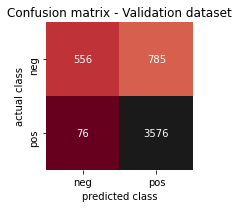

Precision =  0.8199954138958955
Recall =  0.9791894852135816
F1 Score =  0.8925496068888058
Error Rate =  0.17244141798517926
Accuracy =  0.8275585820148208
ROC-AUC 0.6969027217268504


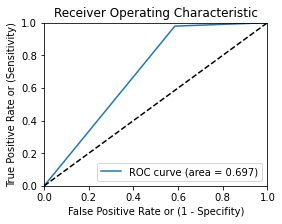

In [34]:
roc_auc = roc_auc_score(Y_test, pred, average= 'micro')

#confusion matrix for count vector
cm = metrics.confusion_matrix(Y_test, pred, labels=[0,1])

#plot the confusion Matrix
plotConfusionMatrix(cm)

rocCurve(Y_test, pred, roc_auc)

#Evaluation
evaluation(cm)
print("ROC-AUC", roc_auc)